In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from functools import partial
from collections import namedtuple

In [2]:
def vec_norm_max(vector: np.array):
    # |v|_1 = max(abs(v_i))
    return np.abs(vector).max()


def vec_norm_sum(vector: np.array):
    # |v|_2 = sum(abs(v_i))
    return np.abs(vector).sum()

def vec_norm_euclid(vector: np.array):
    return np.sqrt((vector ** 2.0).sum())


def row_sum_norm(matrix: np.array):
    # |A|_1 = max( sum(a_ij) for j ) over 1 <= i <= n
    return np.sum(np.abs(matrix), axis=1).max()


def column_sum_norm(matrix: np.array):
    # |A|_2 = max( sum(a_ij) for i ) over 1 <= j <= n
    return np.sum(np.abs(matrix), axis=0).max()


def spectral_norm(matrix: np.array):
    matrix_h = matrix.conj().T
    eigenvalues = np.linalg.eigvals(np.matmul(matrix_h, matrix))
    return np.sqrt(eigenvalues.max())


def get_cond(matrix_a: int, norm):
    inv_matrix_a = np.linalg.inv(matrix_a)
    norm_a = norm(matrix_a)
    norm_inv_a = norm(inv_matrix_a)
    return norm_a * norm_inv_a


## Task 1

In [3]:
def getAIJ(i, j, n):
    return 10.0 / (i + j + 1)
    
def createMatrix(n: int):
    a = np.zeros((n, n))
    from_0_to_n = [i for i in range(n)]
    for i, j in itertools.product(from_0_to_n, from_0_to_n):
        a[i, j] = getAIJ(i, j, n)
    return a

def createF(n: int):
    return np.sum(createMatrix(n), axis=1)

In [4]:
def forwardSubstitution(l, f):
    dim = l.shape[0]
    x = np.zeros(dim)
    for i in range(dim):
        tmp = f[i]
        for j in range(i):
            tmp -= l[i, j] * x[j]
        x[i] = tmp / l[i, i]
    return x

def backwardSubstitution(u: np.array, f: np.array):
    dim = u.shape[0]
    x = np.zeros(dim)
    for i in range(dim - 1, -1, -1):
        tmp = f[i]
        for j in range(i + 1, dim):
            tmp -= u[i, j] * x[j]
        x[i] = tmp / u[i, i]
    return x


def solveLU(l, u, f):
    y = lower_solve(l, f)
    x = upper_solve(u, y)
    return x

In [5]:
n = 6

In [6]:
def LUDecomposition(M):
    U = M.copy()
    n, m = U.shape[0], U.shape[1]
    L = np.diag(np.ones((n)))
    if (n != m):
        raise RuntimeError("Non-square matrices are not allowed")
    for It in range(n):
        for i in range(It+1, n):
            if (U[It,It] == 0):
                continue
            Coef = U[i,It]/U[It,It]
            L[i, It] = Coef
            for j in range(m):
                U[i,j] -= Coef * U[It,j]
    return L, U

def solveLU(L, U, b):
    z = forwardSubstitution(L, b)
    return backwardSubstitution(U, z)

def solveSystem (M, b):
    L, U = LUDecomposition(M)
    return solveLU(L, U, b)

In [7]:
def solveFirstTask(n: int):
    a = createMatrix(n)
    f = createF(n)
    l = np.linalg.cholesky(a)
    x = solveLU(l, l.T, f)
    print(f"a = \n{a}")
    print(f"f = \n{f}")
    print("\nSolution:")
    print(f"L = \n{l}")
    print(f"x = \n{x}")
    # Find the exact solution with numpy and compare results
    exact_x = np.linalg.solve(a, f)
    delta = exact_x - x
    print(f"|delta|_1 = {vec_norm_max(delta):#e}")
    print(f"|delta|_2 = {vec_norm_sum(delta):#e}")
    print(f"|delta|_3 = {vec_norm_euclid(delta):#e}")

In [8]:
solveFirstTask(n)

a = 
[[10.          5.          3.33333333  2.5         2.          1.66666667]
 [ 5.          3.33333333  2.5         2.          1.66666667  1.42857143]
 [ 3.33333333  2.5         2.          1.66666667  1.42857143  1.25      ]
 [ 2.5         2.          1.66666667  1.42857143  1.25        1.11111111]
 [ 2.          1.66666667  1.42857143  1.25        1.11111111  1.        ]
 [ 1.66666667  1.42857143  1.25        1.11111111  1.          0.90909091]]
f = 
[24.5        15.92857143 12.17857143  9.95634921  8.45634921  7.36544012]

Solution:
L = 
[[3.16227766 0.         0.         0.         0.         0.        ]
 [1.58113883 0.91287093 0.         0.         0.         0.        ]
 [1.05409255 0.91287093 0.23570226 0.         0.         0.        ]
 [0.79056942 0.82158384 0.35355339 0.05976143 0.         0.        ]
 [0.63245553 0.73029674 0.40406102 0.11952286 0.01505847 0.        ]
 [0.52704628 0.65205066 0.42089689 0.16600397 0.03764616 0.00378358]]
x = 
[1. 1. 1. 1. 1. 1.]
|delta|_1

## Task 2

In [9]:
def simpleIter(
    a: np.array,
    f: np.array,
    tau,
    eps,
    norm=vec_norm_euclid,
    max_iter= 1000000,
) -> np.array:
    assert a.ndim == 2
    assert f.ndim == 1
    assert a.shape[0] == a.shape[1]
    assert a.shape[0] == f.shape[0]

    dim = a.shape[0]
    tau_f = f * tau
    cur = np.zeros(dim)
    b = np.eye(dim) - tau * a
    err_list = []

    for i in range(max_iter):
        cur = np.matmul(b, cur) + tau_f
        err = f - np.matmul(a, cur)
        norm_err = norm(err)
        err_list.append(norm_err)
        if norm_err < eps:
            return (cur, err_list)
    raise RuntimeWarning("Simple iteration diverges")

In [10]:
Gershgorin = namedtuple("Gershgorin", "a r")

def getGershgorin(a):
    circles = []
    for i, row in enumerate(a):
        a_ii = a[i, i]
        r_i = np.abs(row).sum() - a_ii
        circles.append(Gershgorin(a_ii, r_i))
    return circles

In [11]:
def getAIJ(i: int, j: int, n: int):
    if i == j:
        return 2.0 + (i / n) ** 2.0
    elif j == i - 1 or j == i + 1:
        return -1.0
    elif (i == 0 and j == n - 1) or (i == n - 1 and j == 0):
        return -1.0
    else:
        return 0.0


def createMatrix(n: int) -> np.array:
    a = np.zeros((n, n))
    from_0_to_n = [i for i in range(n)]
    for i, j in itertools.product(from_0_to_n, from_0_to_n):
        a[i, j] = getAIJ(i, j, n)
    return a


def createF(n: int) -> np.array:
    def getFi(i):
        return (1.0 + n**2.0 * np.sin(np.pi / n) ** 2.0) * np.sin(
            (2.0 * np.pi * i) / n
        )

    return np.array([getFi(i) for i in range(n)])

In [12]:
# Compute coefficients of a polynomial
def computePolyChar(a: np.array, y0: np.array):
    dim = a.shape[0]
    y_matrix = np.zeros((dim, dim))
    y = y0
    for i in range(dim - 1, -1, -1):
        y_matrix[:, i] = y
        y = np.matmul(a, y)
    # Matrix is not necessaryli normal, so cholesky method does not apply in all cases
    # LUP decomposition is still hand-rolled. See crude-math/include/crude/linalg/lu.hpp
    ps = solveSystem(y_matrix, y)
    return np.concatenate([np.ones(1), -1.0 * ps])

In [13]:
def plotGershgorin(ax: plt.Axes, eigvals: np.array, circles: list, **kwargs):
    max_x = 0.0
    min_x = 0.0
    for a, r in circles:
        circle = plt.Circle((a.real, 0.0), r, **kwargs)
        ax.add_patch(circle)
        max_x = max(max_x, a.real + r)
        min_x = min(min_x, a.real - r)
    max_dim = max(abs(max_x), abs(min_x))
    ax.set_xlim((min_x, max_x))
    ax.set_ylim((-max_dim, max_dim))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    ax.grid(True, which="both")
    ax.set_xlabel("$Re(\lambda)$")
    ax.set_ylabel("$Im(\lambda)$")
    plt.rcParams.update({"figure.autolayout": True})
    ys = np.zeros(eigvals.shape[0])
    ax.scatter(eigvals, ys, color="red")

In [14]:
def plotFunction(ax: plt.Axes, xs: np.array, ys: list, **kwargs):
    plot = ax.plot(xs, ys, **kwargs)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    ax.grid(True, which="both")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    plt.rcParams.update({"figure.autolayout": True})
    return plot

In [15]:
def solveNewton(x0, f, der, eps, max_iter=1000000) -> np.array:
    cur = x0
    for i in range(max_iter):
        delta = f(cur) / der(cur)
        cur -= delta
        if abs(delta) < eps:
            return cur
    raise RuntimeWarning(
        "Newton's method does not converge or is slowly converging")

In [16]:
def getRoots(coeffs: np.array, stpts: np.array, eps):
    def f(x):
        return np.polyval(coeffs, x)
    def der(x):
        return np.polyval(np.polyder(coeffs), x)
    return np.array([solveNewton(st, f, der, eps=eps) for st in stpts])

In [17]:
def print_sep():
    print("\n----\n")

In [18]:
def do_solve_with_tau(
    a, f, eps, tau, comment="any", norm=vec_norm_euclid
):
    (solution, errs) = simpleIter(a, f, tau, eps)
    exact_sol = np.linalg.solve(a, f)
    delta = solution - exact_sol
    print("\n----\n")
    print(f"Solution with tau = {tau} ({comment}):")
    print(solution)
    print(f"Norm of |exact - sol| = {norm(delta)}")
    return errs

In [19]:
n = 6  # size on system
a = createMatrix(n)
f = createF(n)

In [20]:
print(f'a = \n{a}')
print(f'f = \n{f}')

a = 
[[ 2.         -1.          0.          0.          0.         -1.        ]
 [-1.          2.02777778 -1.          0.          0.          0.        ]
 [ 0.         -1.          2.11111111 -1.          0.          0.        ]
 [ 0.          0.         -1.          2.25       -1.          0.        ]
 [ 0.          0.          0.         -1.          2.44444444 -1.        ]
 [-1.          0.          0.          0.         -1.          2.69444444]]
f = 
[ 0.00000000e+00  8.66025404e+00  8.66025404e+00  1.22464680e-15
 -8.66025404e+00 -8.66025404e+00]


In [21]:
coeffs = computePolyChar(a, np.ones(n))

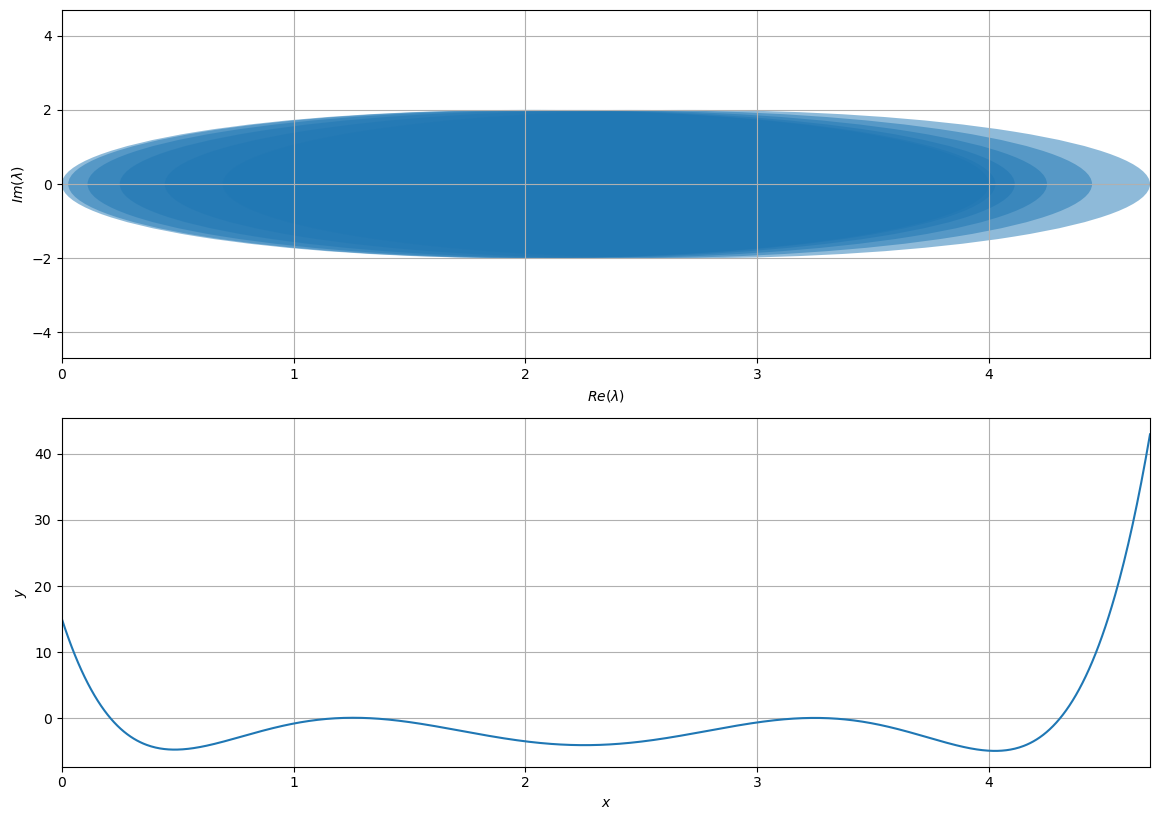

In [22]:
# Plot polynomial to find starting points for newton's method
fig, (ax_gersh, ax_poly) = plt.subplots(2, 1, figsize=(11.7, 8.3))
plotGershgorin(ax_gersh, np.array([]), getGershgorin(a), alpha=0.5)
left, right = ax_gersh.get_xlim()
xs = np.linspace(left, right, 1000)
plotFunction(ax_poly, xs, np.polyval(coeffs, xs))
ax_poly.set_xlim(ax_gersh.get_xlim())
fig.savefig("task2-part1.pdf", transparent=False, bbox_inches="tight")

In [23]:
eps = 1e-6

# Step 2. Computing eigenvals
for i, (c, r) in enumerate(getGershgorin(a)):
    print(f"|lambda_{i}' - {c}| <= {r}")

# Krylov method
krylov_eigvals = getRoots(coeffs, [0.0, 1.0, 1.5, 3.0, 3.5, 4.25], eps=eps)
exact_eigvals = np.linalg.eigvals(a)
krylov_eigvals.sort()
exact_eigvals.sort()

print("\n-- Krylov eigenvals --\n")
for i, v in enumerate(krylov_eigvals):
    print(f"lambda_{i} = {v}")

print("\n-- Numpy eigenvals --\n")
for i, v in enumerate(exact_eigvals):
    print(f"lambda_{i} = {v}")

tau_any = 0.20
tau_opt_krylov = 2.0 / (krylov_eigvals.min() + krylov_eigvals.max())
tau_opt_numpy = 2.0 / (exact_eigvals.min() + exact_eigvals.max())

print("\n----\n")
print(f"tau_opt_numpy\t= {tau_opt_numpy}")
print(f"tau_opt_krylov\t= {tau_opt_krylov}")

bound_solve = partial(do_solve_with_tau, a=a, f=f, eps=eps)

errs_some = bound_solve(tau=tau_any, comment="some value")
errs_krylov = bound_solve(tau=tau_opt_krylov, comment="opt with krylov")
errs_numpy = bound_solve(tau=tau_opt_numpy, comment="opt with numpy")

|lambda_0' - 2.0| <= 2.0
|lambda_1' - 2.0277777777777777| <= 2.0
|lambda_2' - 2.111111111111111| <= 1.9999999999999996
|lambda_3' - 2.25| <= 2.0
|lambda_4' - 2.4444444444444446| <= 2.0
|lambda_5' - 2.6944444444444446| <= 2.0

-- Krylov eigenvals --

lambda_0 = 0.21074228926813396
lambda_1 = 1.172353655693442
lambda_2 = 1.3444997499925393
lambda_3 = 3.1720988450434975
lambda_4 = 3.3221222467008236
lambda_5 = 4.305960991079267

-- Numpy eigenvals --

lambda_0 = 0.21074228926852
lambda_1 = 1.172353655693412
lambda_2 = 1.344499749992459
lambda_3 = 3.1720988450437133
lambda_4 = 3.3221222467005886
lambda_5 = 4.3059609910790835

----

tau_opt_numpy	= 0.44280083854569274
tau_opt_krylov	= 0.4428008385457126

----

Solution with tau = 0.2 (some value):
[ 5.3478266  12.93976584 12.23088945  4.22074719 -2.73420791 -2.24411219]
Norm of |exact - sol| = 4.551685315972811e-06

----

Solution with tau = 0.4428008385457126 (opt with krylov):
[ 5.34782662 12.93976583 12.23088947  4.22074718 -2.73420789 -

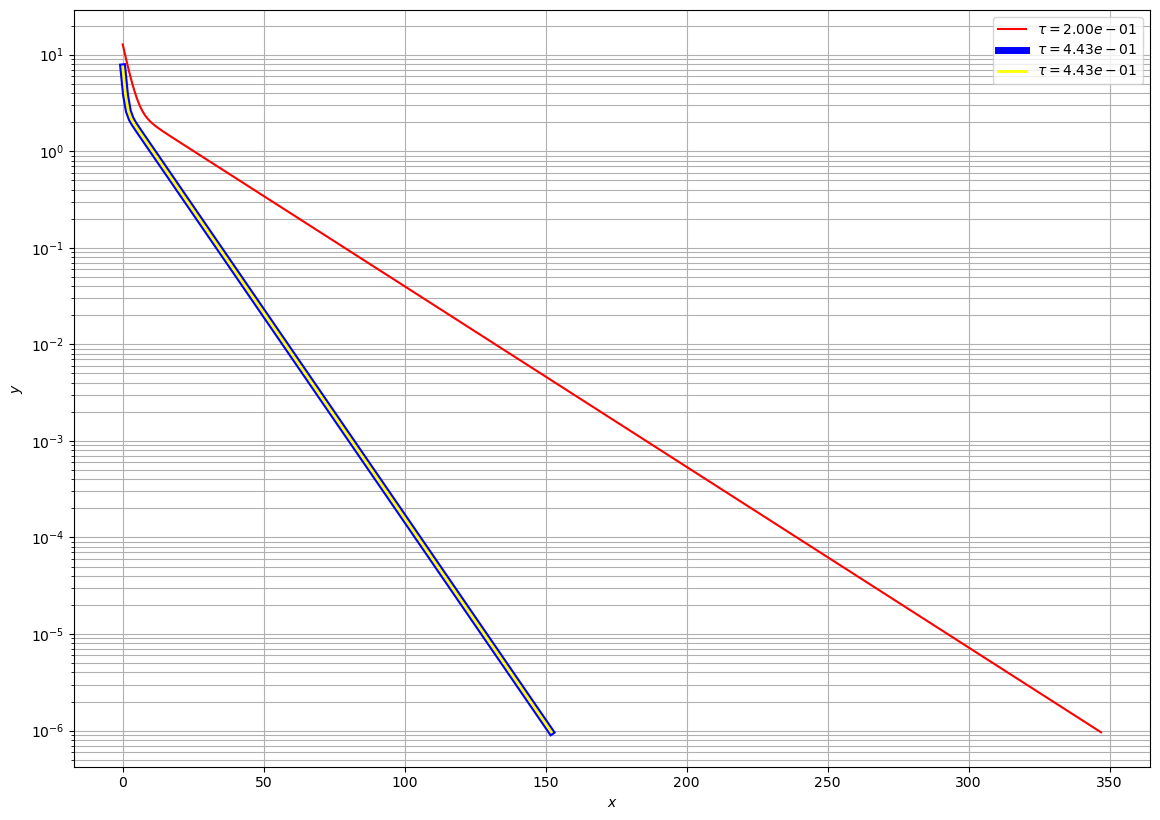

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(11.7, 8.3))

ax.set_yscale('log')
plot_some = plotFunction(ax, np.arange(0, len(errs_some)), errs_some, color="red")
plot_krylov = plotFunction(ax, np.arange(0, len(errs_krylov)), errs_krylov, color="blue", linewidth=5)
plot_numpy = plotFunction(ax, np.arange(0, len(errs_numpy)), errs_numpy, color="yellow", linewidth=2)

ax.legend([plot_some[0], plot_krylov[0], plot_numpy[0]],
          [f'$\\tau = {tau_any:1.2e}$',
           f'$\\tau = {tau_opt_krylov:1.2e}$',
           f'$\\tau = {tau_opt_numpy:1.2e}$'],
          loc='upper right')

fig.savefig("task2-part2.pdf", transparent=False, bbox_inches="tight")